## Dataset preparation


In [5]:
import polars as pl

In [6]:
img_df = pl.read_csv("abo-images-small/images/metadata/images.csv")
img_df = img_df.filter((pl.col("height") >= 1000) & (pl.col("width") >= 1000))

In [ ]:
img_df.shape

(342878, 4)

In [4]:
img_df.head()

image_id,height,width,path
str,i64,i64,str
"""21LlmxUCtTS""",1080,1920,"""46/4689906d.png"""
"""41++65Gq75L""",1000,1000,"""0c/0cd7596c.jpg"""
"""41+-6PFLrzL""",1000,1000,"""e6/e602a9af.jpg"""
"""41+3Rii3WqL""",1000,1000,"""e7/e7cfeb02.jpg"""
"""41+7D+3hkuL""",1200,1200,"""68/6839db4e.jpg"""


In [74]:
img_df = img_df.with_columns(
    pl.lit("abo-images-small/images/small/").add(pl.col("path")).alias("path")
)


In [75]:
image_paths = list(img_df.select(pl.col("path")).to_series())

## Model selection and understanding


**What is the vector size produced by clip-ViT-B-32?**

- The vector size produced by the clip-ViT-B-32 model is 512 dimensions.

**What do ViT, B and 32 mean in the model name?**

- ViT stands for Vision Transformer, B indicates the base model size, and 32 refers to the patch size of 32x32 pixels used in the model.


In [17]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("clip-ViT-B-32")

## Database setup

- I am using the one from labs


In [37]:
from sqlalchemy import URL

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port="5555",
    database="similarity_search_service_db",
)

In [38]:
from sqlalchemy.engine import create_engine

engine = create_engine(db_url)

In [ ]:
from sqlalchemy.orm import DeclarativeBase


class Base(DeclarativeBase):
    __abstract__ = True

In [46]:
from sqlalchemy.orm import Mapped, mapped_column
from pgvector.sqlalchemy import Vector


class Img(Base):
    __tablename__ = "images"
    __table_args__ = {"extend_existing": True}

    VECTOR_LENGTH: int = 512

    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str]
    embedding: Mapped[list[float]] = mapped_column(Vector(VECTOR_LENGTH))

/var/folders/8j/_nnvcqj93gvgk18wygygd9tw0000gn/T/ipykernel_6459/65331261.py:5: SAWarning: This declarative base already contains a class with the same class name and module name as __main__.Img, and will be replaced in the string-lookup table.
  class Img(Base):


In [47]:
Base.metadata.create_all(engine)

## Image Vectorization


In [ ]:
import joblib
from PIL import Image
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session
from itertools import batched

MAX_IMAGES = 256
BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)


def insert_images(engine, images: list[Img]):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()


def vectorize_images(engine, model: SentenceTransformer, image_paths):
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(image_paths, MAX_IMAGES):
            images = [
                Image.open(path)
                for path in images_paths_batch
            ]

            # calculate embeddings
            embeddings = model.encode(images, batch_size=MAX_IMAGES)

            # create Img instances for all images in batch
            img_instances = [
                Img(image_path=img_path, embedding=embedding)
                for img_path, embedding in zip(images_paths_batch, embeddings)
            ]
            # insert all batch images
            insert_images(engine, img_instances)

            # update pbar
            pbar.update(len(images))


vectorize_images(engine, model, image_paths)

  0%|          | 0/256 [00:00<?, ?it/s]

In [76]:
import matplotlib.pyplot as plt
from IPython.display import display
from IPython.display import Image as IPImage
from sqlalchemy import select


class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model

    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        images = [f"abo-images-small/images/small/{img.image_path}" for img in found_images]
        self.display_images(images, k)

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(
            image_description
        )  # calculate embedding of image_description

        # remember about session and commit
        query = (
            select(Img)
            .order_by(Img.embedding.cosine_distance(image_embedding))
            .limit(k)
        )
        with Session(self.engine) as session:
            result = session.execute(query, execution_options={"prebuffer_rows": True}).scalars().all()
        return result

    def display_images(self, images, k):
        fig, axes = plt.subplots(1, k, figsize=(15, 5))

        for i, img_path in enumerate(images):
            img = Image.open(img_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i + 1}")

        plt.show()

In [77]:
img_search = ImageSearch(engine, model)

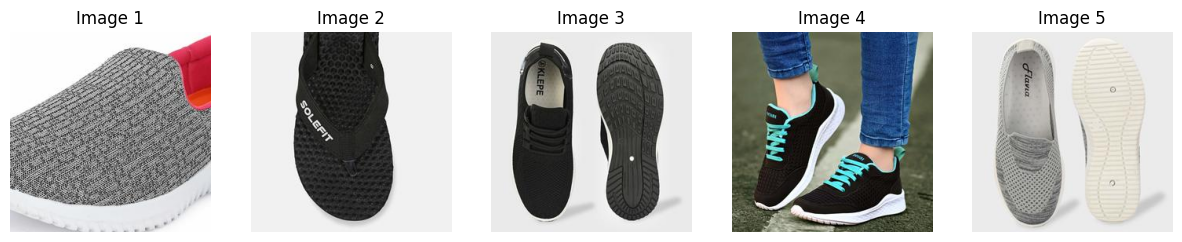

In [78]:
img_search("Shoe", 5)

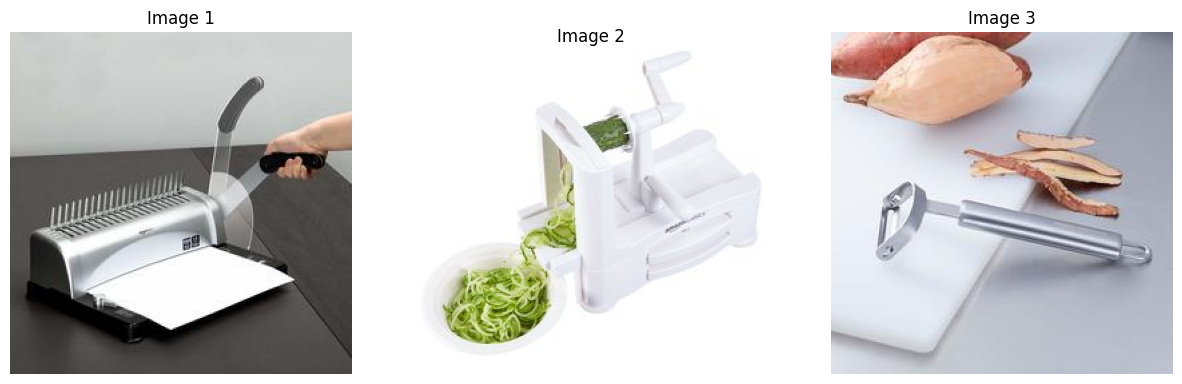

In [79]:
img_search("food slicer", 3)

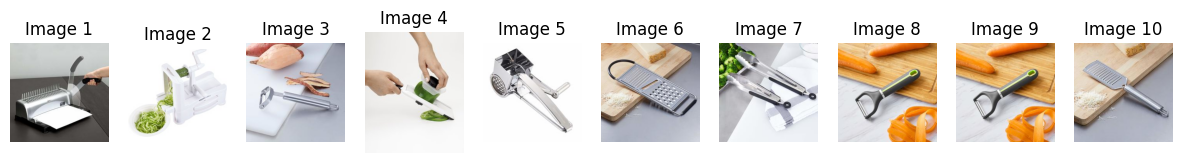

In [80]:
img_search("food slicer", 10)

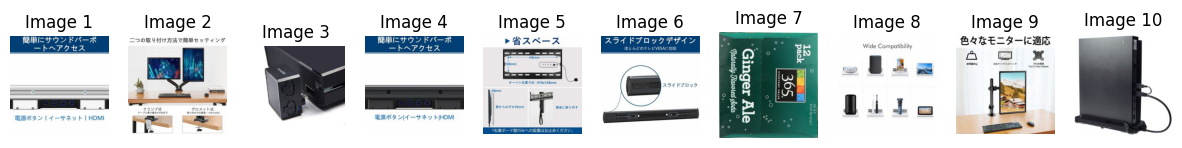

In [81]:
img_search("pc hardware", 10)

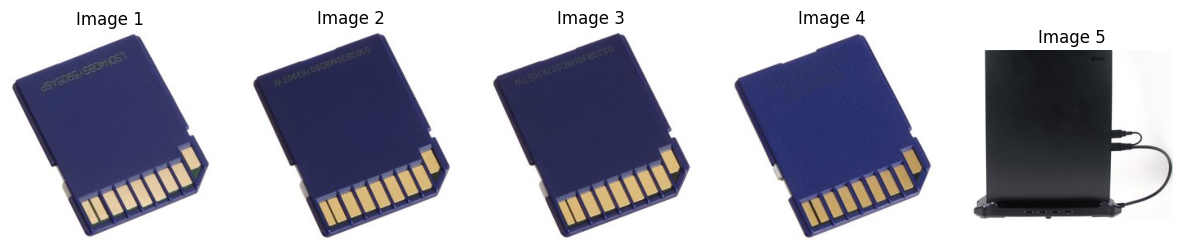

In [82]:
img_search("computer processor", 5)

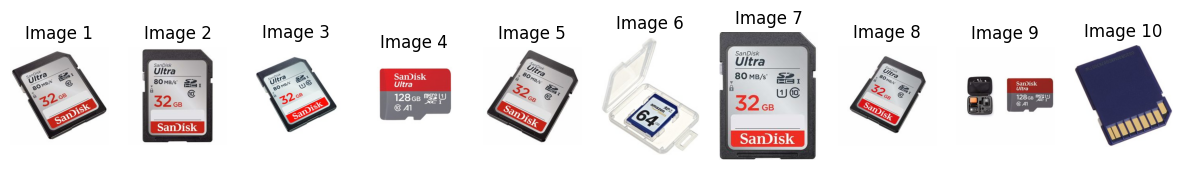

In [86]:
img_search("SD card", k=10)

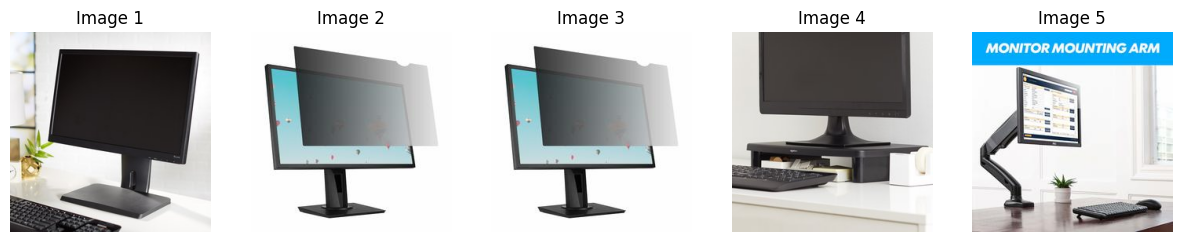

In [83]:
img_search("A computer monitor", 5)

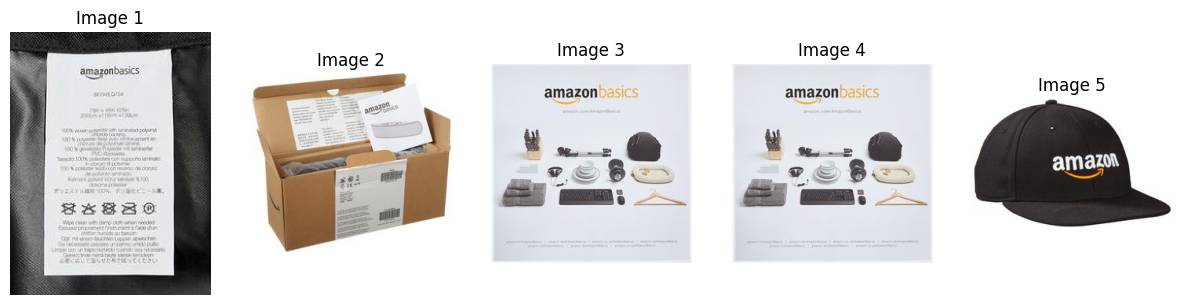

In [84]:
img_search("amazon", 5)

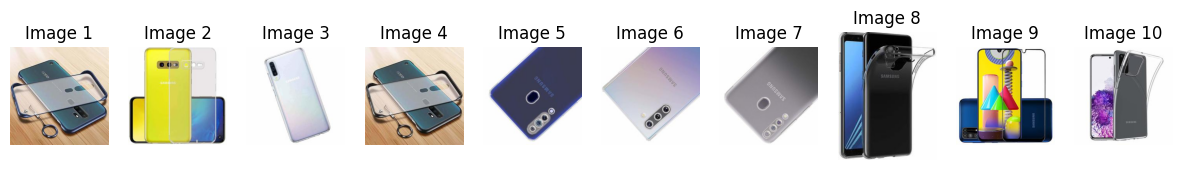

In [87]:
img_search("samsung", 10)

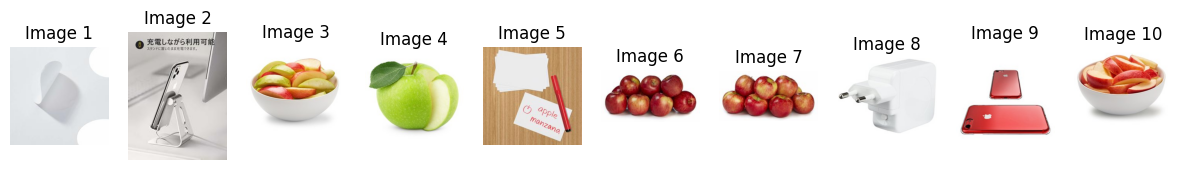

In [88]:
img_search("apple", 10)

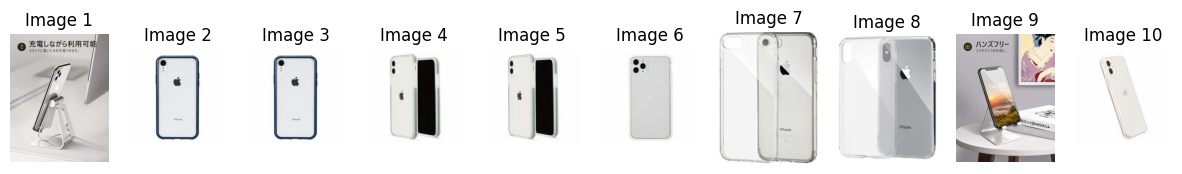

In [89]:
img_search("IPhone", 10)

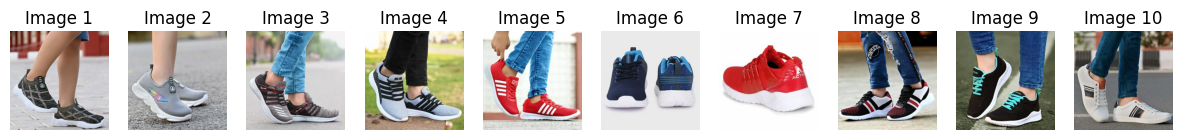

In [90]:
img_search("adidas", 10)

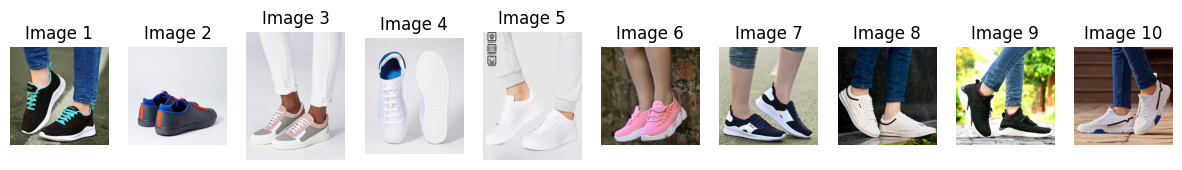

In [91]:
img_search("Sneakers", 10)